In [1]:
import numpy as np
import random
import torch
import importlib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import sys
sys.path.append('../')

from models.network import AutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

## dataload
### create dataset
data_path = r'./../data/all_vox256_img/all_vox256_img_test.hdf5'
samples = ImNetImageSamples(data_path=data_path)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## folder for testing
is_svr = True
epoch = 1000
use_phase = not is_svr
phase = 2
arc = 'resnet18'

testing_folder = fr'./../pretrain/new_arch/image_encoder_{arc}' if is_svr else './../pretrain/origin/phase_2_model'
config_path = os.path.join(testing_folder, 'config.py')
network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase and not is_svr else ""}_{epoch}.pth')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [3]:
## loading index
sample_interval = 1
resolution = 64
max_batch = 20000
save_deformed = True
thershold = 0.01
with_surface_point = True

device_count = 1 # torch.cuda.device_count()
device_ratio = 1
worker_nums = int(device_count * device_ratio)

args = [(samples[i][0][0], resolution, max_batch, (-0.5, 0.5), thershold,
         samples.obj_paths[i], with_surface_point, i) for i in range(len(samples)) if
        i % sample_interval == 0]
random.shuffle(args)

splited_args = split(args, worker_nums)
final_args = [(splited_args[i], network_path, config_path, i % device_count) for i in range(worker_nums)]

((1, 128, 128), <matplotlib.image.AxesImage at 0x7f804a944eb0>)

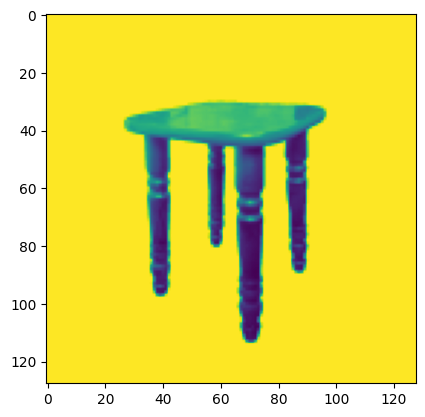

In [4]:
import cv2
target_wh = 128, 128

img = np.ones((1, target_wh[1], target_wh[0]), dtype=np.uint8) * 255

img_loaded = cv2.imread('masked-chair_1.png') # masked-chair_1.png cup-masked.png
if img_loaded.shape[0] > img_loaded.shape[1]:
    res_wh = (
        int(img_loaded.shape[1] / (img_loaded.shape[0] // target_wh[0])), 
        target_wh[1]
    )
else:
    res_wh = (
        target_wh[0],
        int(img_loaded.shape[0] / (img_loaded.shape[1] // target_wh[1])), 
    )
    
additional_shift_wh = (
    (target_wh[0] - res_wh[0])//2,
    (target_wh[1] - res_wh[1])//2
)

img_loaded = cv2.resize(img_loaded, res_wh, interpolation=cv2.INTER_AREA)
img_loaded = img_loaded[..., 0]
img[:, additional_shift_wh[1]: res_wh[1]+additional_shift_wh[1], additional_shift_wh[0]: res_wh[0] + additional_shift_wh[0]] = img_loaded
img = img.astype(np.float32)
img /= 255
img.shape, plt.imshow(img[0])

(64,
 20000,
 (-0.5, 0.5),
 0.01,
 '04256520/db7851745fb04cf732388c13cc4a0ba3',
 True)

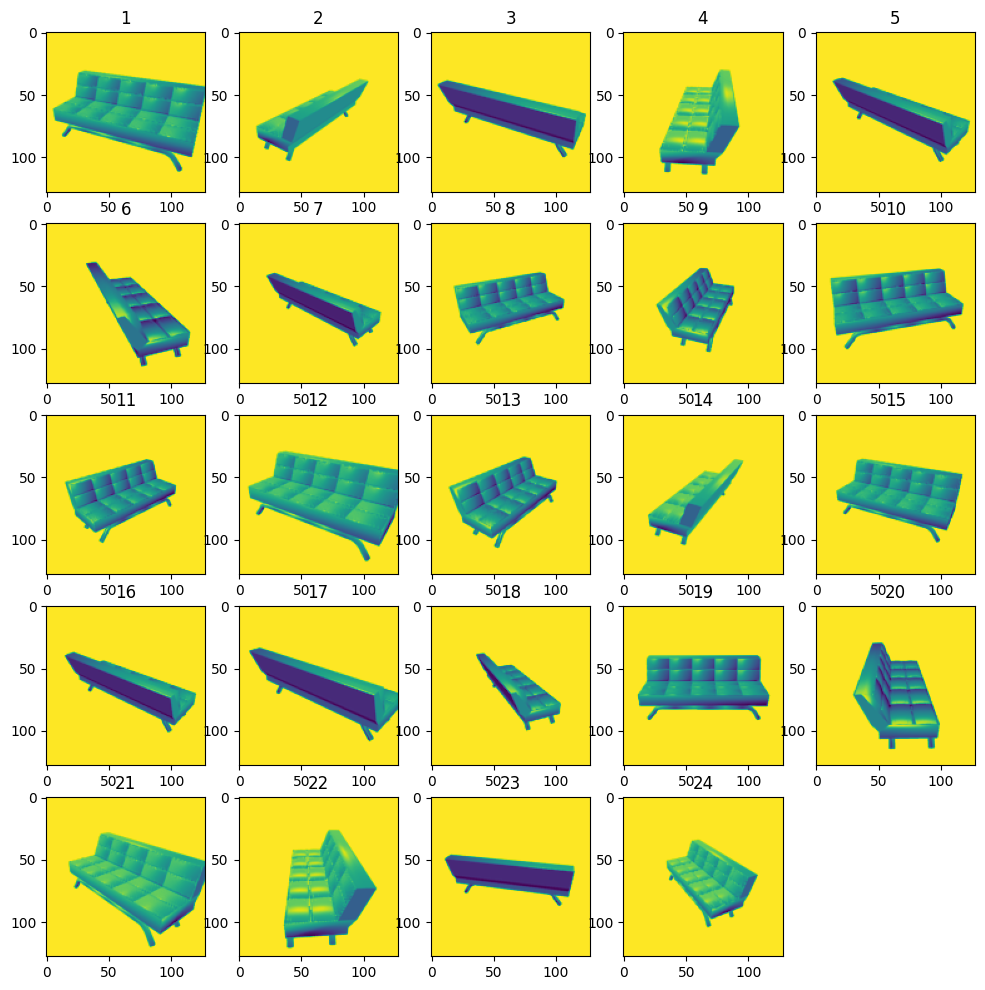

In [5]:
indx = 0
obj_indx = 6
find_obj_name = '04256520/db7851745fb04cf732388c13cc4a0ba3' 
# '03001627/d66b701631851e7b4b19d2c99e22ffe0'
# '04256520/db7851745fb04cf732388c13cc4a0ba3'
# '02691156/fb0f2907b977e7cb67c5e3041553656b' 
# '03001627/d16b62da42fa61f0cbce248a4e686c70'

img, resolution, max_batch, space_range, thresh, obj_path, sur_point, indx_sample = final_args[indx][0][obj_indx]

if find_obj_name is not None:
    indx_sample = samples.obj_paths.index(find_obj_name)
    img = samples.data_pixels[indx_sample, 0]
    obj_path = find_obj_name
    
gt_voxel, gt_points, gt_values = (
    samples.data_voxels[indx_sample], 
    samples.data_points[indx_sample], 
    samples.data_values[indx_sample]
)
net_path, conf_path = final_args[indx][1:-1]

all_img_view = samples.data_pixels[indx_sample].copy()

fig = plt.figure(figsize=(12, 12))
for i in range(1, len(all_img_view)+1):
    ax = fig.add_subplot(5,5,i)
    plt.imshow(np.squeeze(all_img_view[i-1]))
    plt.title(i)

resolution, max_batch, space_range, thresh, obj_path, sur_point

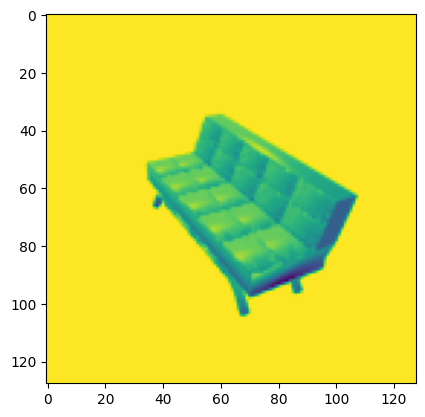

In [6]:
img = all_img_view[23] / 255.0
plt.imshow(img[0])

In [8]:
os.makedirs('test_tsne', exist_ok=True)

In [122]:
from tqdm import tqdm

arc_original = 'original'
arc_list = [arc_original, 'resnet18', 'resnet18bn', 'resnet34', 'resnet34bn', 'resnet50']
class_name_list_all = [
    "02691156_airplane",
    "02828884_bench",
    "02933112_cabinet",
    "02958343_car",
    "03001627_chair",
    "03211117_display",
    "03636649_lamp",
    "03691459_speaker",
    "04090263_rifle",
    "04256520_couch",
    "04379243_table",
    "04401088_phone",
    "04530566_vessel",
]
class2indx = dict([(name_class.split('_')[0], i) for i, name_class in enumerate(class_name_list_all)])


for arc in tqdm(arc_list):
    ## folder for testing
    is_svr = True
    epoch = 1000
    use_phase = not is_svr
    phase = 2
    if arc == arc_original:
        testing_folder = fr'./../pretrain/origin/image_encoder' if is_svr else './../pretrain/origin/phase_2_model'
    else:
        testing_folder = fr'./../pretrain/new_arch/image_encoder_{arc}' if is_svr else './../pretrain/origin/phase_2_model'
    config_path = os.path.join(testing_folder, 'config.py')
    network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase and not is_svr else ""}_{epoch}.pth')

    ## import config here
    spec = importlib.util.spec_from_file_location('*', config_path)
    config = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(config)

    network_state_dict = torch.load(network_path)
    network_state_dict, is_old_style_weights = AutoEncoder.process_state_dict(network_state_dict, type = 1)

    if is_svr:
        if is_old_style_weights and config.encoder_type.upper() == '3DCNN':
            config = AutoEncoder.fix_old_weights_config(config)
        if not os.path.exists(config.auto_encoder_config_path):
            config.auto_encoder_config_path = os.path.join('./..', config.auto_encoder_config_path)
            config.auto_encoder_resume_path = os.path.join('./..', config.auto_encoder_resume_path)
        assert hasattr(config, 'auto_encoder_config_path') and os.path.exists(config.auto_encoder_config_path)
        auto_spec = importlib.util.spec_from_file_location('*', config.auto_encoder_config_path)
        auto_config = importlib.util.module_from_spec(auto_spec)
        auto_spec.loader.exec_module(auto_config)

        network = AutoEncoder(config=config)

        voxel_auto_encoder = AutoEncoder(config=auto_config)
        network_voxel_state_dict = torch.load(config.auto_encoder_resume_path)
        network_voxel_state_dict, _ = AutoEncoder.process_state_dict(network_voxel_state_dict, type = 1)
        voxel_auto_encoder.load_state_dict(network_voxel_state_dict)
        voxel_auto_encoder.to(device)
        voxel_auto_encoder.eval()
    else:
        network = AutoEncoder(config=config).to(device)
    network.load_state_dict(network_state_dict)
    network = network.to(device)
    _ = network.eval()
    
    all_emb_list = []
    all_label_list = []
    with torch.no_grad():
        for _, resolution, max_batch, space_range, thresh, obj_path, sur_point, indx_sample in final_args[0][0][:2_000]:
            img = samples.data_pixels[indx_sample, 23].copy() / 255.0
            if is_svr:
                embedding = network(torch.from_numpy(img).float().to(device).unsqueeze(0))
                #embedding = voxel_auto_encoder(torch.from_numpy(gt_voxel).float().to(device).unsqueeze(0))
            else:
                embedding = network(torch.from_numpy(gt_voxel).float().to(device).unsqueeze(0))
            all_emb_list.append(embedding.detach().cpu().numpy())
            all_label_list.append(class2indx[obj_path.split('/')[0]])
    np.save(f'./test_tsne/{arc}.npy', np.concatenate(all_emb_list, axis=0))
    np.save(f'./test_tsne/{arc}_label.npy', np.stack(all_label_list, axis=0))

  0%|          | 0/6 [00:00<?, ?it/s]

old style weights


100%|██████████| 6/6 [00:35<00:00,  5.86s/it]


In [49]:
import time

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [115]:
all_emb_read_list = []
y = []
for i, arc_name in enumerate(arc_list):
    all_emb_read_list.append(np.load(f'./test_tsne/{arc_name}.npy'))
    y += [i] * len(all_emb_read_list[-1])
X = np.concatenate(all_emb_read_list, axis=0).copy()
feat_cols = [ 'feature'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X, columns=feat_cols)
df['y'] = np.array(y, dtype=np.int32)
df['label'] = df['y'].apply(lambda i: str(i))

In [124]:
y = np.load('./test_tsne/original_label.npy')
X = np.load('./test_tsne/original.npy')
feat_cols = [ 'feature'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X, columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: class_name_list_all[i].split('_')[1])

In [125]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.19910632 0.12030634 0.09274846]


In [126]:
np.random.seed(42)

rndperm = np.random.permutation(df.shape[0])

/tmp/ipykernel_54431/1850670429.py:2: UserWarning: 
The palette list has fewer values (10) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<AxesSubplot: xlabel='pca-one', ylabel='pca-two'>

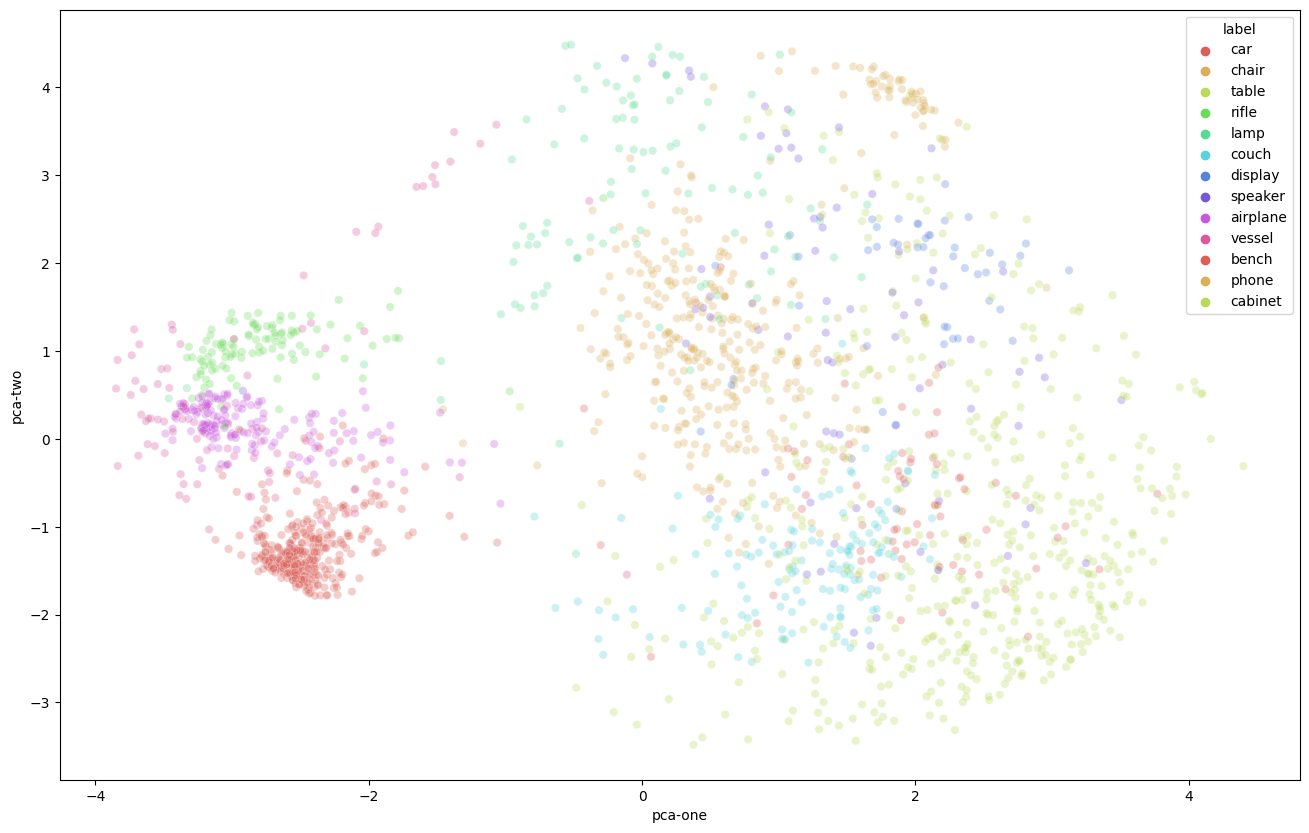

In [127]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

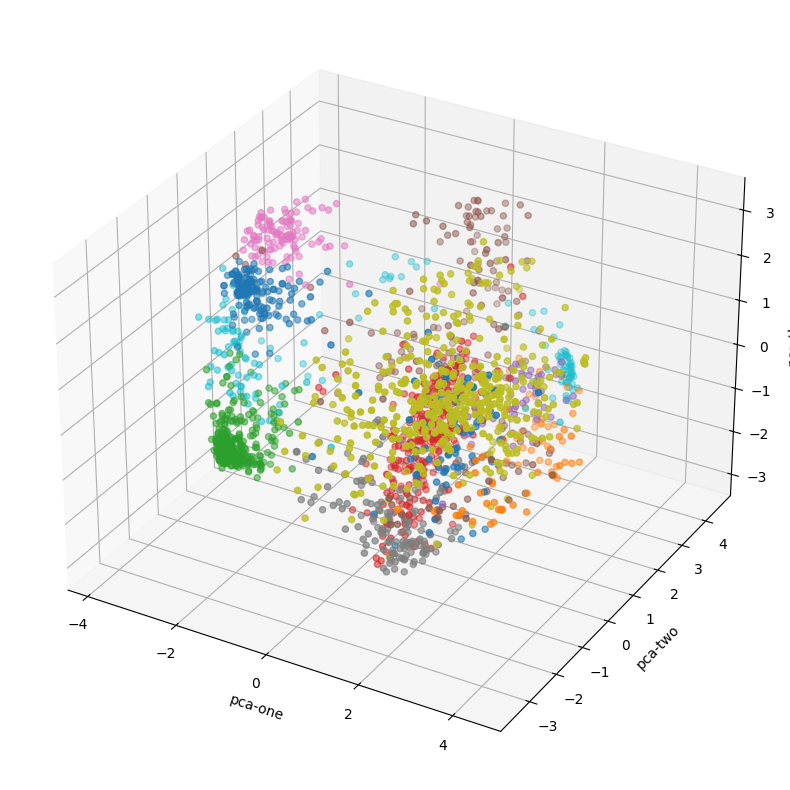

In [128]:
ax = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [129]:
N = 10000

df_subset = df.loc[rndperm[:N],:].copy()

data_subset = df_subset[feat_cols].values

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.19910622 0.12030648 0.09274836]


In [130]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.453464
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.854370
[t-SNE] KL divergence after 300 iterations: 0.926774
t-SNE done! Time elapsed: 1.2851426601409912 seconds


In [131]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

In [133]:
parts_tsne = []
new_y_part_list = []
slice_number = 10
for y_i in range(len(arc_list)):
    parts_tsne.append(tsne_results[y_i == y][:slice_number])
    new_y_part_list += [y_i] * slice_number

parts_tsne_np = np.concatenate(parts_tsne, axis=0)

feat_cols = [ 'feature'+str(i) for i in range(X.shape[1]) ]

df_subset = pd.DataFrame({'tsne-2d-one': parts_tsne_np[:, 0], 'tsne-2d-two': parts_tsne_np[:, 1], 'y': new_y_part_list})

/tmp/ipykernel_54431/975371238.py:2: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

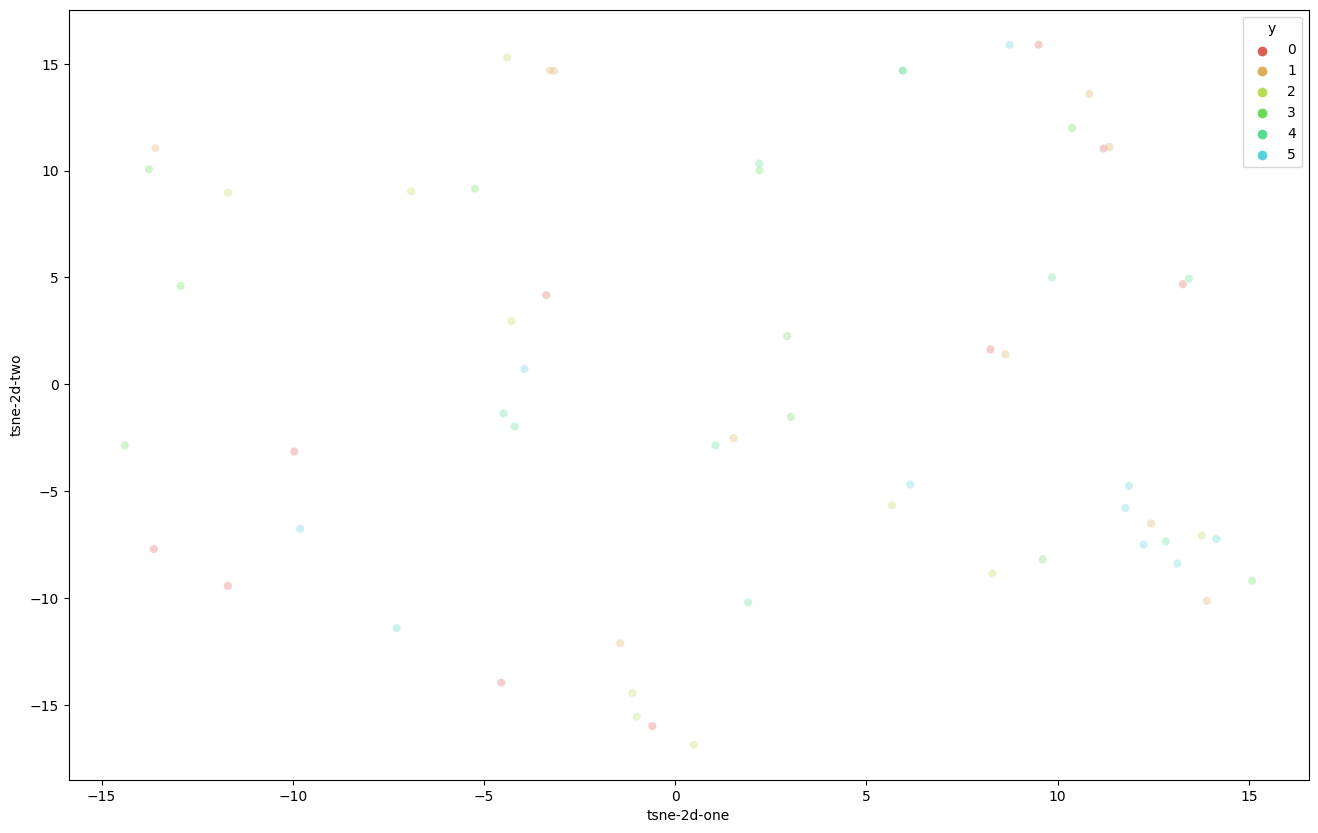

In [134]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

ValueError: Could not interpret value `pca-one` for parameter `x`

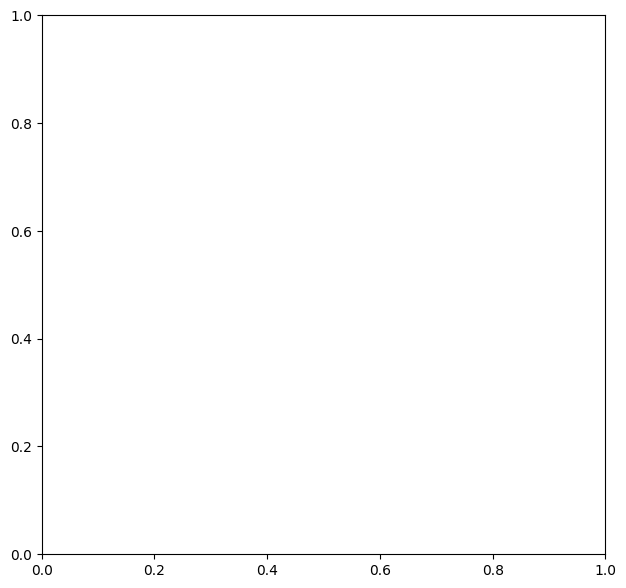

In [114]:
plt.figure(figsize=(16,7))

ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)

ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

In [32]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)

print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9325670003890991


In [33]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 0.296245813369751 seconds


/tmp/ipykernel_54431/2441613910.py:5: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_54431/2441613910.py:16: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_54431/2441613910.py:27: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='tsne-pca50-one', ylabel='tsne-pca50-two'>

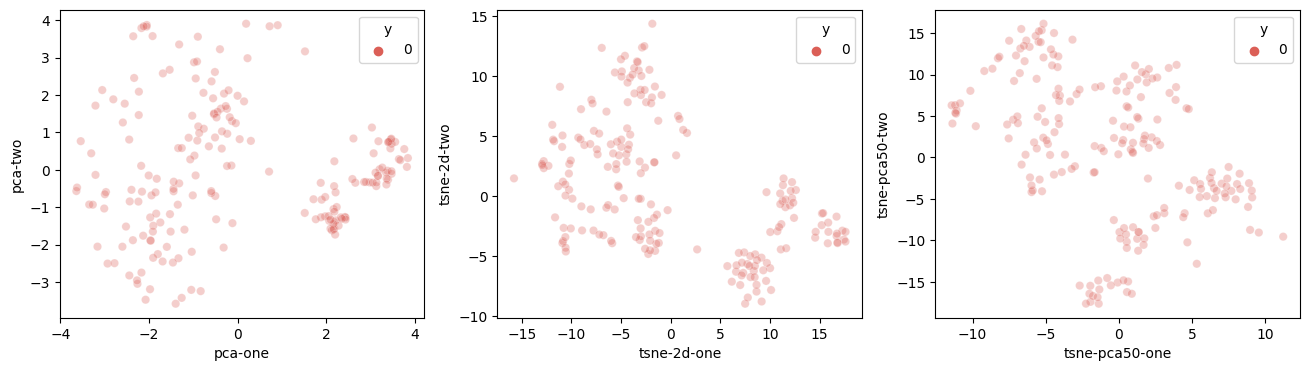

In [34]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

In [62]:
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

(vertices, polygons, vertices_deformed, polygons_deformed, 
 embedding, vertices_convex, bsp_convex_list,
 convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
    inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
    space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
)

In [63]:
from utils.other_utils import write_ply_polygon

write_ply_polygon('mesh_deformed.ply', vertices_deformed, polygons_deformed)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)

/tmp/ipykernel_54044/849803873.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(embedding.detach().cpu())


<AxesSubplot: ylabel='Density'>

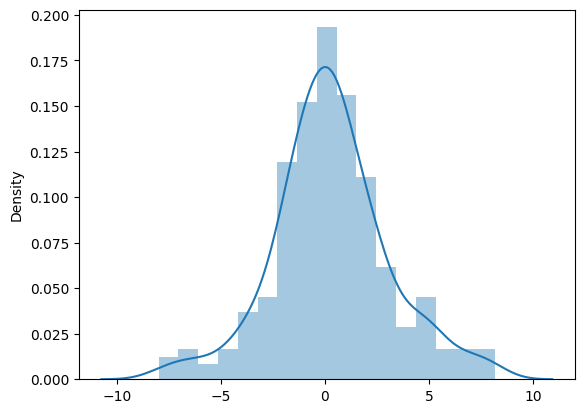

In [21]:
import seaborn as sns

sns.distplot(embedding.detach().cpu())

In [14]:
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

(vertices, polygons, vertices_deformed, polygons_deformed, 
 embedding, vertices_convex, bsp_convex_list,
 convex_predictions_sum, point_value_prediction) = voxel_auto_encoder.save_bsp_deform(
    inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
    space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
)

In [15]:
from utils.other_utils import write_ply_polygon

write_ply_polygon('mesh_deformed.ply', vertices_deformed, polygons_deformed)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)